In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import pickle
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
imdb_data=pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

In [5]:
def review_preprocessing():
    
    X = imdb_data['review']  
    X=X.str.lower()
    X = X.replace({'<.*?>': ''}, regex = True)
    X = X.replace({'\s+[a-zA-Z]\s+':' '},regex=True)
    X = X.replace({'\s+':' '},regex=True)
    X = X.replace({'[^A-Za-z]': ' '}, regex = True)     
    return X

X= np.asarray(review_preprocessing())


In [6]:
y = imdb_data['sentiment']
y = y.replace('positive', 1)
y = y.replace('negative', 0)
y=np.asarray(y)

In [7]:
print(X.shape)
print(y.shape)

(50000,)
(50000,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
from transformers import DistilBertTokenizer, TFDistilBertModel

In [10]:
tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer,handle)

In [14]:
max_length=128

def convert_to_input(reviews):
  input_ids=[]
  attention_masks=[]
  token_type_ids=[]  
  for x in tqdm(reviews,position=0, leave=True):
    inputs = tokenizer.encode_plus(x,                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        max_length = max_length, # max length of the text that can go to BERT
                        pad_to_max_length = True, # add [PAD] tokens
                        truncation=True,
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
                        return_token_type_ids=True
                       )
    
  
    
    input_ids.append(inputs["input_ids"])
    attention_masks.append(inputs["attention_mask"])
    token_type_ids.append(inputs["token_type_ids"])
  
  return [np.asarray(input_ids), np.asarray(attention_masks), np.asarray(token_type_ids)]

X_test_input=convert_to_input(X_test)
X_train_input=convert_to_input(X_train)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 40000/40000 [03:34<00:00, 186.22it/s]


In [15]:
def example_to_features(input_ids,attention_masks,token_type_ids,y):
  return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y
          
train_ds = tf.data.Dataset.from_tensor_slices((X_train_input[0],X_train_input[1],X_train_input[2],y_train)).map(example_to_features).shuffle(10000).batch(32)


test_ds=tf.data.Dataset.from_tensor_slices((X_test_input[0],X_test_input[1],X_test_input[2],y_test)).map(example_to_features).batch(32)

In [16]:
from transformers import TFDistilBertForSequenceClassification


In [17]:
model=None
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [18]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filepath = "/content/drive/MyDrive/bertmodel-{epoch:02d}-{val_loss:.2f}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',              #to save the model after every epoch if val loss decrease
                                                 save_best_only=True,
                                                 mode='max',
                                                 verbose=1)
                         #to stop the training early if val loss doesn't decreases from last 5 epoch
                                                 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

bert_history = model.fit(train_ds, epochs=2, validation_data=test_ds, callbacks=[checkpoint])

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bertmodel-01-0.28/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bertmodel-01-0.28/assets


Epoch 2/2
1250/1250 [==============================] - 553s 443ms/step - loss: 0.1919 - accuracy: 0.9254 - val_loss: 0.2954 - val_accuracy: 0.8936

Epoch 00002: val_accuracy improved from 0.88160 to 0.89360, saving model to /content/drive/MyDrive/bertmodel-02-0.30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bertmodel-02-0.30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bertmodel-02-0.30/assets


In [ ]:
model.save_pretrained('/content/drive/MyDrive/savemodel')

In [ ]:
model.evaluate(test_ds)

313/313 [==============================] - 43s 136ms/step - loss: 0.2954 - accuracy: 0.8936


[0.2954218089580536, 0.8935999870300293]

In [ ]:
y_pred = tf.nn.softmax(m.predict(test_ds)[0])
y_pred_argmax = tf.math.argmax(y_pred, axis=1)
y_true = tf.Variable([], dtype=tf.int64)

for features, label in test_ds.take(-1):
    y_true = tf.concat([y_true, label], 0)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4731
           1       0.92      0.88      0.90      5269

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



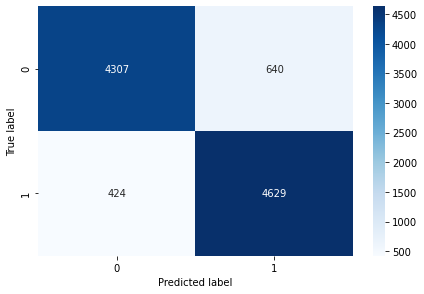

In [ ]:
def visualize_confusion_matrix(y_pred_argmax, y_true):
   cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred_argmax, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


visualize_confusion_matrix(y_pred_argmax, y_true)